## 多腕バンディット問題 (Multi-armed bandit problem)

source : これからの機械学習（森北出版）

---

### 問題設定
腕がK本あるスロットマシンを考える。  
払い戻される額をR、腕i (i = 1, 2, ..., K)を引いた場合のあたりが出る確率をpkとする。  
また、スロットマシンの状態は試行中に変化しないものとする。  
  
確率値pkが既知であれば、プレイヤーの最適な戦略は最大のR*pkを与える腕kを選び続けることである。  
しかしpkが未知であるとき、どのように腕を選べば払戻額を最大化することができるだろうか。  

In [1]:
# スロットマシンのプログラム
import numpy as np


class slotmachine(object):
    def __init__(self, 
                 reward_price=500, 
                 cost=100, 
                 distribution=(0.2, 0.3, 0.4, 0.5)):

        # 各スロットマシンの報酬Rとあたりが出る確率pkを定義する
        self.distributions = {}
        for i in range(len(distribution)):
            self.distributions[i] = (reward_price, distribution[i])
        self.reward_price = reward_price
        self.cost = cost
    
    def action_space(self):
        return len(self.distributions)
    
    def reward_space(self):
        return (self.reward_price, 0)

    def play(self, action):
        (R, p) = self.distributions[action]
        hit = np.random.choice([0, 1], 1, p=[1-p, p])[0]
        reward = R * hit - self.cost
        return reward, int(hit)

In [6]:
# ランダムに１０００回引いてみる
m = slotmachine()
money = 1000
action_space_size = m.action_space()
trial_num = 1000
print_timing = 100

print("選択肢の数 =",  action_space_size)

for i in range(trial_num):
    action = np.random.choice(range(action_space_size))
    reward, hit = m.play(action)
    money += reward
    hit_message = "hit!" if hit==1 else "miss"
    if (i+1)%print_timing==0:
        print("trial = {0}, last action = {1}, {2}, money = {3}".format(i+1, action, hit_message, money))

選択肢の数 = 4
trial = 100, last action = 2, miss, money = 7500
trial = 200, last action = 3, miss, money = 14000
trial = 300, last action = 3, hit!, money = 24000
trial = 400, last action = 1, miss, money = 30500
trial = 500, last action = 1, miss, money = 37500
trial = 600, last action = 3, miss, money = 45000
trial = 700, last action = 1, miss, money = 54500
trial = 800, last action = 1, miss, money = 65000
trial = 900, last action = 2, miss, money = 70500
trial = 1000, last action = 0, hit!, money = 77000


---

### greedyアルゴリズム
Algorithm
>まだn回選んだことがない腕がある場合、その腕を選ぶ  
>それ以外の場合、すべての腕に対して、これまでの報酬の平均を計算する  
>　　　　vi = (これまで腕iから得られた報酬の和) / (これまで腕iをプレイした回数)  
>viが最大の腕を選ぶ  

In [2]:
class Agent_greedy(object):
    def __init__(self, action_space_size, min_choose=1, initial_play_count=0, expected_reward=None):
        self.action_space_size = action_space_size
        self.play_count = initial_play_count
        self.min_choose = min_choose
        
        # expected_reward[action_number] = (selected_count, sum of rewards, avarage of rewards)
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0.]
        else:
            self.expected_reward = expected_reward
            
    def act(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][2] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][2] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action
        
    def update(self, action, reward):
        self.play_count += 1
        self.expected_reward[action][0] += 1
        self.expected_reward[action][1] += reward
        self.expected_reward[action][2] = self.expected_reward[action][1] / self.expected_reward[action][0]

    def load_record(self, initial_play_count, expected_reward):
        self.play_count = initial_play_count
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0.]
        else:
            self.expected_reward = expected_reward
        
    def save_record(self):
        return self.play_count, self.expected_reward

    def reset_record(self):
        self.play_count = 0
        self.expected_reward = {}
        for i in range(action_space_size):
            self.expected_reward[i] = [0, 0., 0.]
    
    def sum_reward(self):
        sum_reward = 0
        for value in self.expected_reward.values():
            sum_reward += value[1]
        return sum_reward
    
    def debug_sum(self):
        for action in self.expected_reward:
            print("self.expected_reward[{0}]".format(action), self.expected_reward[action])
        print("sum_reward", self.sum_reward())
        #print("sum_reward_fix", self.sum_reward_fix())
    
    def action_count(self):
        action_count = []
        for value in self.expected_reward.values():
            action_count.append(value[0])
        return action_count
        

In [24]:
# 動作例
m = slotmachine()
money = 0
action_space_size = m.action_space()

agent = Agent_greedy(action_space_size, min_choose=3)

for i in range(1000):
    action = agent.act()
    reward, hit = m.play(action)
    agent.update(action, reward)
    money += reward
    #hit_message = "hit!" if hit==1 else "miss"
    #print("action = {0}, {1}, money = {2}".format(action, hit_message, money))
    if (i+1)%100==0:
        print("try:{0}, money={1}".format(i+1, money))

try:100, money=15000
try:200, money=33500
try:300, money=48500
try:400, money=64500
try:500, money=78000
try:600, money=95000
try:700, money=110500
try:800, money=123000
try:900, money=141000
try:1000, money=153000


このアルゴリズムは、  
・最適ではない腕i'の報酬の期待値Rpi'を、最適な腕iの期待値Rpiよりも大きいと誤認したとき、  
　試行回数を増加すればいつかは訂正できる  
  
しかし、  
・最適な腕iの報酬の期待値Rpiが他のある腕i'の期待値Rpi'よりも小さいと誤認したとき、  
　試行回数をいくら増加させても訂正できるとは限らない  
という問題がある。
  
このリスクを前言させ、探索コストを減らす手法の一つとして、  
下記のε-greedyアルゴリズムが知られている。  

### ε-greedyアルゴリズム
Algorithm
>まだ選んだことがない腕がある場合、その腕から一つ選ぶ  
>確率εで、すべての腕からランダムに一つ選ぶ  
>確率1-εで、これまでの報酬の平均viが最大の腕を選ぶ  

In [3]:
class Agent_e_greedy(Agent_greedy):
    def __init__(self, action_space_size, epsilon=0.1, min_choose=1):
        super(Agent_e_greedy, self).__init__(action_space_size, min_choose)
        self.epsilon = epsilon

    def act_greedy(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][2] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][2] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action    
        
    def act(self):
        if np.random.choice([1, 0], p=[self.epsilon, 1-self.epsilon]):
            action = int(np.random.choice(range(action_space_size)))
        else:
            action = self.act_greedy()
        return action
    

探索と利用のトレードオフを解く方法として  
「不確かなときは楽観的に (optimism in face of uncertainty)」という原理が知られている。  
  
この原理を用いた多腕バンディット問題の解放として、  
Upper Confidence Bound (UCB) アルゴリズムが有名である。  

### UCB1アルゴリズム
Algorithm  
>R : 払戻額の最大値と最小値の差  
>まだ選んだことのない腕があれば、そのうちの一つを選ぶ  
>各々の腕iから得られる報酬の期待値を計算する。  
>　　　　vi = (これまで腕iから得られた報酬の和) / (これまで腕iを選んだ回数)  
>各々の腕iから得られる報酬の信頼区間の半幅を計算する  
>　　　　Ui = R * root( (2ln(これまでの総プレイ回数)) / (これまで腕iをプレイした回数) )  
>vi + Ui が最大の腕iを選ぶ  

In [4]:
from math import sqrt, log

class Agent_ucb1(object):
    def __init__(self, action_space_size, reward_space=(500,0), min_choose=1,
                 initial_play_count = 0, expected_reward=None):
        self.action_space_size = action_space_size
        self.play_count = initial_play_count
        self.min_choose = min_choose
        self.reward_width = abs(reward_space[0] - reward_space[1])
        
        # expected_reward[action_number] = (selected_count, sum of rewards, 
        #                                   avarage of rewards, 1/2 * Confidence interval of reward,
        #                                   average + 1/2*CI)
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0., 0., 0.]
        else:
            self.expected_reward = expected_reward

    def act(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][4] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][4] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action
        
    def update(self, action, reward):
        self.play_count += 1
        self.expected_reward[action][0] += 1
        self.expected_reward[action][1] += reward
        self.expected_reward[action][2] = self.expected_reward[action][1] / self.expected_reward[action][0]
        self.expected_reward[action][3] = self.reward_width * sqrt((2*log(self.play_count)) / (self.expected_reward[action][0]))
        self.expected_reward[action][4] = self.expected_reward[action][2] + self.expected_reward[action][3]
    
    def load_record(self, initial_play_count, expected_reward):
        self.play_count = initial_play_count
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0., 0., 0.]
        else:
            self.expected_reward = expected_reward
    
    def save_record(self):
        return self.play_count, self.expected_reward
    
    def reset_record(self):
        self.play_count = 0
        self.expected_reward = {}
        for i in range(action_space_size):
            self.expected_reward[i] = [0, 0., 0., 0., 0.]
        
    def sum_reward(self):
        sum_reward = 0
        for value in self.expected_reward.values():
            sum_reward += value[1]
        return sum_reward
    
    def action_count(self):
        action_count = []
        for value in self.expected_reward.values():
            action_count.append(value[0])
        return action_count

---

### 性能比較
参考文献の設定に従い、K=4の場合のシミュレーションを行う。  
４つの腕の払戻額は同じ（１とする）で、払戻率はそれぞれ0.2, 0.3, 0.4, 0.5である。  
学習は１エポックあたり100回、これを続けて100エポック繰り返し、
エポック当たりの結果を表示する。  

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def exam_block(agent, trial_num=3, reset_per_epoch=True,
               initial_play_count=0, expected_reward=None):
    # record[trial] = [trial, [each action's selected_count list], sum of reward]
    record = []
    
    if reset_per_epoch==True:
        agent.reset_record()
        agent.load_record(initial_play_count, expected_reward)
    
    for trial in range(trial_num):
        action = agent.act()
        reward, hit = m.play(action)
        agent.update(action, reward)
        record.append([trial, agent.action_count(), agent.sum_reward()])
    
    save_data = agent.save_record()
    
    return record, save_data


def epoch_block(agent, epoch_num=3, trial_num=3, reset_per_epoch=True,
                initial_play_count=0, expected_reward=None):
    # total_record[trial] = [trial, [each action's total selected_count], total reward]
    record = []
    total_record = []
    reward_per_epoch=[]
    action_rate_per_epoch=[]
    last_reward = 0
    
    play_count = 0
    if expected_reward is None:
        expected_reward = {}
    save_data = (play_count, expected_reward)
    
    for epoch in range(epoch_num):
        record,save_data = exam_block(agent, 
                                      trial_num=trial_num,
                                      reset_per_epoch=reset_per_epoch,
                                      initial_play_count=save_data[0],
                                      expected_reward=save_data[1])
        if len(total_record)==0:
            total_record = record
        else:
            for trial in range(trial_num):
                for action in range(action_space_size):
                    #total_record[trial][1][action] += record[trial][1][action]
                    total_record[trial][1][action] = record[trial][1][action]
                    total_record[trial][2] = record[trial][2]

        reward_per_epoch.append(record[-1][2] - last_reward)
        last_reward = record[-1][2]
        
        action_rate_per_epoch.append(record[-1][1])
        record_per_epoch = (reward_per_epoch, action_rate_per_epoch)
            
    return total_record, record_per_epoch


def draw_learning_graph(total_record, record_per_epoch, 
                        row=4, col=1, num=1, 
                        title="", color=["r", "g", "b", "c", "m", "y", "k", "w"], 
                        action_space_size=4, trial_num=3, epoch_num=3, reset_per_epoch=True, 
                        x=None, 
                        xmin=0, xmax=3, ymin=0, ymax=3):
    action_records=[]
    
    for action in range(action_space_size):
        action_record = []
        
        for epoch in range(epoch_num):
            record_val = record_per_epoch[1][epoch][action] / sum(record_per_epoch[1][epoch])
            action_record.append(record_val)
        
        action_records.append(action_record)      

    plt.subplot(row, col, num)
    
    x=np.array(range(0, epoch_num)) if x is None else x
    
    ymaxline = np.array([ymax for i in range(epoch_num)])
    yminline = np.array([ymin for i in range(epoch_num)])
    y = []

    for action_num in range(action_space_size):
        y.append(action_records[action_num])
        
    y = np.array(y)
    
    ysum = []
    for action in range(action_space_size+1):
        ysum.append([])
        if action > 0:
            ysum[action] = ysum[action-1] - y[action-1]
        else:
            ysum[action] = ymaxline
    y = np.vstack((ysum, yminline))
    
    for action_num in range(action_space_size):
        plt.fill_between(x, y[action_num], y[action_num+1], 
                         facecolor = color[action_num%len(color)], alpha=0.5)

    plt.title(title)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    
def draw_reward_graph(rewards_per_epoch, 
                      row=4, col=1, num=4, 
                      title="Average reward", color=["r", "g", "b", "c", "m", "y", "k", "w"], 
                      agent_name=None,
                      trial_num=3, epoch_num=3, 
                      reward_max=1, reward_min=0, expected_ideal_reward=1*0.5,
                      x=None,ymax=None,ymin=None,
                      epsilon=1e-8):
    plt.subplot(row, col, num)
    x = np.array(range(1, epoch_num+1)) if x is None else x
    
    # rewards_per_epoch[record][epoch_number] = sum_of_reward
    for record in range(len(rewards_per_epoch)):
        y = []
        max_val = 0
        val_record = np.array(rewards_per_epoch[record])
        for epoch in range(len(rewards_per_epoch[record])):
            reward_rate = val_record[epoch] / (reward_max * trial_num)
            y.append(reward_rate)
            
            max_val = max(max_val, reward_rate)
        y = np.array(y)
        
        if agent_name is not None:
            plt.plot(x, y, color = color[record], label=agent_name[record])
        else:
            plt.plot(x, y, color = color[record])
            
    plt.hlines([expected_ideal_reward], 0, epoch_num, linestyles="dashed")
        
    if agent_name is not None:
        plt.legend()
    if reward_max<max_val:
        reward_max=max_val
    if ymax is None:
        ymax = reward_max
    if ymin is None:
        ymin = reward_min
    plt.title(title)
    plt.xlim(1, epoch_num-1)
    plt.ylim(ymin, ymax)
        


slot machine's settings: 
  arm,  chance of hit, color on glaph
 0   0.04   r 
 1   0.08   g 
 2   0.12   b 
 3   0.16   c 
 4   0.2   m 
 5   0.24   y 



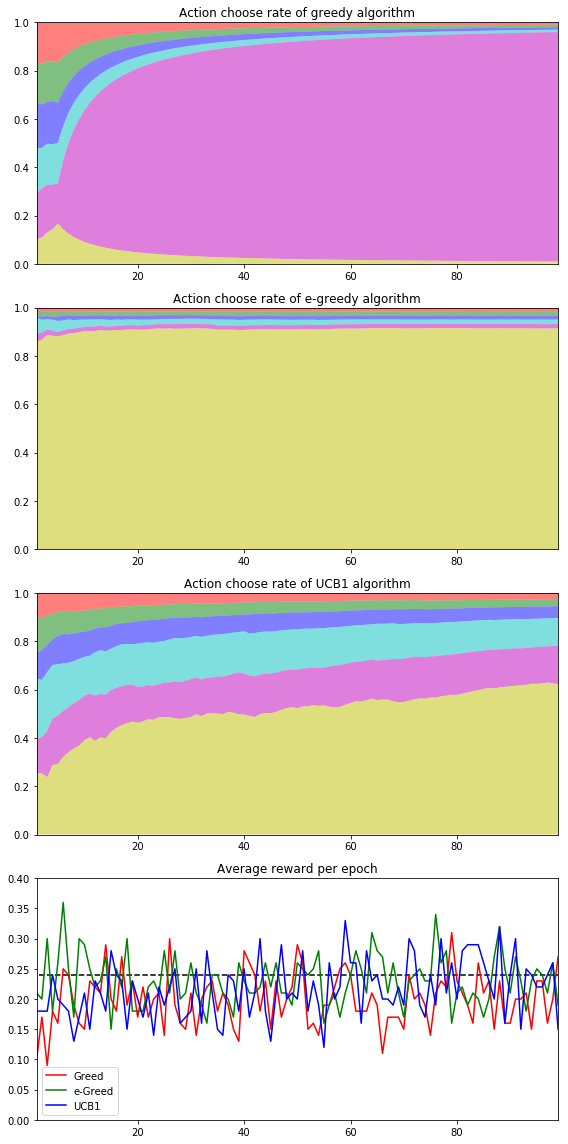

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

reward_price = 1
distribution=(0.04, 0.08, 0.12, 0.16, 0.20, 0.24)

m = slotmachine(reward_price=reward_price,
                cost=0, 
                distribution=distribution)
action_space_size = m.action_space()
reward_space_size = m.reward_space()

initial_play_count = 0
expected_reward = {}

agent_greed = Agent_greedy(action_space_size, min_choose=100)
agent_e_greed = Agent_e_greedy(action_space_size, epsilon=0.1, min_choose=1)
agent_ucb1 = Agent_ucb1(action_space_size, reward_space=reward_space_size, min_choose=1)

# 100 for debag
trial_num = 100
epoch_num = 100

# for debug
reset_per_epoch = True

total_record_greed, record_per_epoch_greed = \
    epoch_block(agent_greed, epoch_num, trial_num)
total_record_e_greed, record_per_epoch_e_greed = \
    epoch_block(agent_e_greed, epoch_num, trial_num)
total_record_ucb1, record_per_epoch_ucb1 = \
    epoch_block(agent_ucb1, epoch_num, trial_num)

x = np.array(range(0, epoch_num))
#color = ["tomato", "gold", "palegreen", "deepskyblue", "violet"]
color = ["r", "g", "b", "c", "m", "y", "k", "w"]


plt.figure(figsize=(8,16))

draw_learning_graph(total_record_greed, record_per_epoch_greed,
                    row=4, col=1, num=1, 
                    title="Action choose rate of greedy algorithm", color=color,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    reset_per_epoch = reset_per_epoch,
                    x=x, xmin=1, xmax=epoch_num-1, ymin=0, ymax=1)

draw_learning_graph(total_record_e_greed, record_per_epoch_e_greed,
                    row=4, col=1, num=2, 
                    title="Action choose rate of e-greedy algorithm", color=color,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    reset_per_epoch = reset_per_epoch,
                    x=x, xmin=1, xmax=epoch_num-1, ymin=0, ymax=1)

draw_learning_graph(total_record_ucb1, record_per_epoch_ucb1,
                    row=4, col=1, num=3, 
                    title="Action choose rate of UCB1 algorithm", color=color,
                    reset_per_epoch = reset_per_epoch,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    x=x, xmin=1, xmax=epoch_num-1, ymin=0, ymax=1)

draw_reward_graph([record_per_epoch_greed[0], record_per_epoch_e_greed[0], record_per_epoch_ucb1[0]], 
                  row=4, col=1, num=4, 
                  title="Average reward per epoch", color=color, 
                  agent_name=["Greed", "e-Greed", "UCB1"],
                  trial_num=trial_num, epoch_num=epoch_num, 
                  reward_max=1, reward_min=0, 
                  expected_ideal_reward = reward_price*max(distribution),
                  x=np.array(range(0, epoch_num)),ymax=0.4, ymin=0)

setting_text = "\n\
slot machine's settings: \n\
  arm,  chance of hit, color on glaph\n"
  
for action in range(action_space_size):
    setting_text += " {0}   {1}   {2} \n".format(action, distribution[action], color[action%len(color)])
print(setting_text)

plt.tight_layout()
plt.show()